In [1]:
%matplotlib notebook
import sys
sys.path.append('train_eval')
sys.path.append('preprocess')
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.onnx
import onnx
from onnx_tf.backend import prepare
import math
from utils import group_points_2

from IPython.display import Image, display
from preprocess_blender import *

C:\Users\Andrew Jay Zhou\AppData\Roaming\Python\Python36\site-packages\onnx_tf\common\__init__.py:87: UserWarning: FrontendHandler.get_outputs_names is deprecated. It will be removed in future release.. Use node.outputs instead.
  warnings.warn(message)


In [2]:
nstates_plus_1 = [64,64,128]
nstates_plus_2 = [128,128,256]
nstates_plus_3 = [256,512,1024,1024,512]

class PointNet_Plus(nn.Module):
    def __init__(self):
        super(PointNet_Plus, self).__init__()
        self.num_outputs = 26
        self.knn_K = 64
        self.ball_radius2 = 0.04
        self.sample_num_level1 = 512
        self.sample_num_level2 = 128
        self.INPUT_FEATURE_NUM = 6
        
        self.netR_1 = nn.Sequential(
            # B*INPUT_FEATURE_NUM*sample_num_level1*knn_K
            nn.Conv2d(self.INPUT_FEATURE_NUM, nstates_plus_1[0], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_1[0]),
            nn.ReLU(inplace=True),
            # B*64*sample_num_level1*knn_K
            nn.Conv2d(nstates_plus_1[0], nstates_plus_1[1], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_1[1]),
            nn.ReLU(inplace=True),
            # B*64*sample_num_level1*knn_K
            nn.Conv2d(nstates_plus_1[1], nstates_plus_1[2], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_1[2]),
            nn.ReLU(inplace=True),
            # B*128*sample_num_level1*knn_K
            nn.MaxPool2d((1,self.knn_K),stride=1)
            # B*128*sample_num_level1*1
        )
        
        self.netR_2 = nn.Sequential(
            # B*131*sample_num_level2*knn_K
            nn.Conv2d(3+nstates_plus_1[2], nstates_plus_2[0], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_2[0]),
            nn.ReLU(inplace=True),
            # B*128*sample_num_level2*knn_K
            nn.Conv2d(nstates_plus_2[0], nstates_plus_2[1], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_2[1]),
            nn.ReLU(inplace=True),
            # B*128*sample_num_level2*knn_K
            nn.Conv2d(nstates_plus_2[1], nstates_plus_2[2], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_2[2]),
            nn.ReLU(inplace=True),
            # B*256*sample_num_level2*knn_K
            nn.MaxPool2d((1,self.knn_K),stride=1)
            # B*256*sample_num_level2*1
        )
        
        self.netR_3 = nn.Sequential(
            # B*259*sample_num_level2*1
            nn.Conv2d(3+nstates_plus_2[2], nstates_plus_3[0], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_3[0]),
            nn.ReLU(inplace=True),
            # B*256*sample_num_level2*1
            nn.Conv2d(nstates_plus_3[0], nstates_plus_3[1], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_3[1]),
            nn.ReLU(inplace=True),
            # B*512*sample_num_level2*1
            nn.Conv2d(nstates_plus_3[1], nstates_plus_3[2], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_3[2]),
            nn.ReLU(inplace=True),
            # B*1024*sample_num_level2*1
            nn.MaxPool2d((self.sample_num_level2,1),stride=1),
            # B*1024*1*1
        )
        
        self.netR_FC = nn.Sequential(
            # B*1024
            nn.Linear(nstates_plus_3[2], nstates_plus_3[3]),
            nn.BatchNorm1d(nstates_plus_3[3]),
            nn.ReLU(inplace=True),
            # B*1024
            nn.Linear(nstates_plus_3[3], nstates_plus_3[4]),
            nn.BatchNorm1d(nstates_plus_3[4]),
            nn.ReLU(inplace=True),
            # B*512
            nn.Linear(nstates_plus_3[4], self.num_outputs),
            # B*num_outputs
        )
    
    def forward(self, x, y):
        # x: B*INPUT_FEATURE_NUM*sample_num_level1*knn_K, y: B*3*sample_num_level1*1
        x = self.netR_1(x)
        # B*128*sample_num_level1*1
        x = torch.cat((y, x),1).squeeze(-1)
        # B*(3+128)*sample_num_level1
        
        #inputs_level2, inputs_level2_center = group_points_2(x, self.sample_num_level1, self.sample_num_level2, self.knn_K, self.ball_radius2)
        inputs_level2, inputs_level2_center = group_points_2(x, 512, 128, 64, 0.04)
        # B*131*sample_num_level2*knn_K, B*3*sample_num_level2*1
        
        # B*131*sample_num_level2*knn_K
        x = self.netR_2(inputs_level2)
        # B*256*sample_num_level2*1
        x = torch.cat((inputs_level2_center, x),1)
        # B*259*sample_num_level2*1
        
        x = self.netR_3(x)
        # B*1024*1*1
        x = x.view(-1,nstates_plus_3[2])
        # B*1024
        x = self.netR_FC(x)
        # B*num_outputs
        
        return x
    

def group_points_2(points, sample_num_level1, sample_num_level2, knn_K, ball_radius):
    torch.set_printoptions(threshold=10000)
    # group points using knn and ball query
    # points: B*(3+128)*512
    cur_train_size = points.size(0)
    inputs1_diff = points[:,0:3,:].unsqueeze(1).expand(cur_train_size,sample_num_level2,3,sample_num_level1) \
                 - points[:,0:3,0:sample_num_level2].transpose(1,2).unsqueeze(-1).expand(cur_train_size,sample_num_level2,3,sample_num_level1)# B * 128 * 3 * 512
    inputs1_diff = torch.mul(inputs1_diff, inputs1_diff)    # B * 128 * 3 * 512
    inputs1_diff = inputs1_diff.sum(2)                      # B * 128 * 512
    dists, inputs1_idx = torch.topk(inputs1_diff, knn_K, 2, largest=False, sorted=False)  # dists: B * 128 * 64; inputs1_idx: B * 128 * 64

    # ball query
#     invalid_map = dists.gt(ball_radius) # B * 128 * 64, invalid_map.float().sum()   
#     for jj in range(sample_num_level2):
#         inputs1_idx.data[:,jj,:][invalid_map.data[:,jj,:]] =jj
    new_inputs1_idx = ball_query(dists, inputs1_idx) 


    idx_group_l1_long = new_inputs1_idx.view(cur_train_size,1,sample_num_level2*knn_K).expand(cur_train_size,points.size(1),sample_num_level2*knn_K)
    inputs_level2 = points.gather(2,idx_group_l1_long).view(cur_train_size,points.size(1),sample_num_level2,knn_K) # B*131*128*64

    inputs_level2_center = points[:,0:3,0:sample_num_level2].unsqueeze(3)       # B*3*128*1
    tmp = inputs_level2[:,0:3,:,:] - inputs_level2_center.expand(cur_train_size,3,sample_num_level2,knn_K) # B*3*128*64
    inputs_level2 = torch.cat((tmp, inputs_level2[:, 3:, :, :]), dim=1)
    
    
    return inputs_level2, inputs_level2_center
    # inputs_level2: B*131*sample_num_level2*knn_K, inputs_level2_center: B*3*sample_num_level2*1

@torch.jit.script
def ball_query(dists, inputs1_idx):
    idx = inputs1_idx.clone()
    invalid_map = dists.gt(0.04) # B * 128 * 64, invalid_map.float().sum()
    #ball radius 2 = 0.04
    
    # consider optimizing 
    for jj in range(128): #sample_num_level2 = 128
        for k in range(64):
            i = invalid_map[:,jj,k]
            if bool(i == 1):
                idx[:, jj, k] = jj
            
        
    return idx
    
def group_points(points):
    sample_num_level1 = 512
    sample_num_level2 = 128
    ball_radius       = 0.015
    ball_radius2      = 0.04
    SAMPLE_NUM        = 1024
    knn_K             = 64
    INPUT_FEATURE_NUM = 6
    # group points using knn and ball query
    # points: B * 1024 * 6
   
    cur_train_size = len(points)
    inputs1_diff = points[:,:,0:3].transpose(1,2).unsqueeze(1).expand(cur_train_size,sample_num_level1,3, SAMPLE_NUM) \
                 - points[:,0:sample_num_level1,0:3].unsqueeze(-1).expand(cur_train_size,sample_num_level1,3,SAMPLE_NUM)# B * 512 * 3 * 1024
    inputs1_diff = torch.mul(inputs1_diff, inputs1_diff)    # B * 512 * 3 * 1024
    inputs1_diff = inputs1_diff.sum(2)                      # B * 512 * 1024
    dists, inputs1_idx = torch.topk(inputs1_diff, knn_K, 2, largest=False, sorted=False)  # dists: B * 512 * 64; inputs1_idx: B * 512 * 64
        
    # ball query
    invalid_map = dists.gt(ball_radius) # B * 512 * 64
    for jj in range(sample_num_level1):
        inputs1_idx[:,jj,:][invalid_map[:,jj,:]] = jj
        
    idx_group_l1_long = inputs1_idx.view(cur_train_size,sample_num_level1*knn_K,1).expand(cur_train_size,sample_num_level1*knn_K,INPUT_FEATURE_NUM)
    inputs_level1 = points.gather(1,idx_group_l1_long).view(cur_train_size,sample_num_level1,knn_K,INPUT_FEATURE_NUM) # B*512*64*6

    inputs_level1_center = points[:,0:sample_num_level1,0:3].unsqueeze(2)       # B*512*1*3
    inputs_level1[:,:,:,0:3] = inputs_level1[:,:,:,0:3] - inputs_level1_center.expand(cur_train_size,sample_num_level1,knn_K,3)
    inputs_level1 = inputs_level1.unsqueeze(1).transpose(1,4).squeeze(4)  # B*6*512*64
    inputs_level1_center = inputs_level1_center.contiguous().view(-1,1,sample_num_level1,3).transpose(1,3)  # B*3*512*1
    return inputs_level1, inputs_level1_center
    #inputs_level1: B*INPUT_FEATURE_NUM*sample_num_level1*knn_K, inputs_level1_center: B*3*sample_num_level1*1
    
def load_net(weights_file='train_eval/results/iter_003/netR_40.pth', ngpu_trained=4, map_location='cpu'):
    if ngpu_trained > 0:
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')

    netR = PointNet_Plus()
    
    if ngpu_trained > 1:
        netR.netR_1 = nn.DataParallel(netR.netR_1, range(ngpu_trained))
        netR.netR_2 = nn.DataParallel(netR.netR_2, range(ngpu_trained))
        netR.netR_3 = nn.DataParallel(netR.netR_3, range(ngpu_trained))

    netR.load_state_dict(torch.load('train_eval/results/iter_003/netR_40.pth', map_location='cpu'))
    return netR

In [3]:
net = load_net()
net.eval()

dummy_inputs_level1, dummy_input_level1_center = group_points(torch.randn(1, 1024, 6))

dummy_input = (dummy_inputs_level1, dummy_input_level1_center)
traced_script_module = torch.jit.trace(net, dummy_input)

## Evaluate Script Model 

In [14]:
import os
data_root = 'C:\\Users\\Andrew Jay Zhou\\Documents\\Dev\\HandPointNet\\data\\samples'
file_number = "0000"
depth_map = os.path.join(data_root, '{}.exr'.format(file_number))
gt        = os.path.join(data_root, '{}_joint_pos.txt'.format(file_number))
pc, coeff, max_bb3d_len, offset, jnt_xyz_normalized = preprocess(depth_map, gt, add_noise=True)
point_cloud = torch.from_numpy(pc.reshape((1,1024,6))).float()

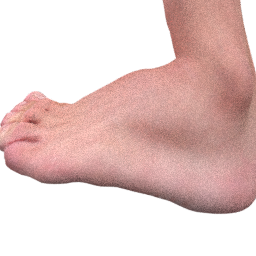

In [7]:
display(Image(filename=os.path.join(data_root, '{}.png'.format(file_number))))

<IPython.core.display.Javascript object>


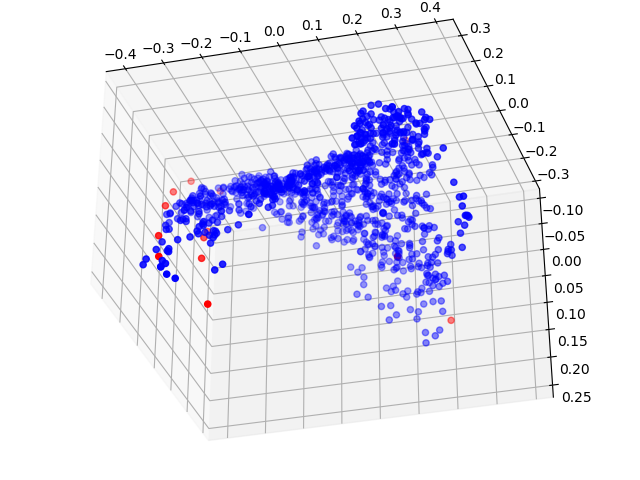

In [8]:
plot(pc,jnt_xyz_normalized)

In [12]:
def infer(point_clout):
    inputs_level1, inputs_level1_center = group_points(point_cloud)
    estimation = traced_script_module(inputs_level1, inputs_level1_center)
    
    # PCA
    PCA_data_path = 'C:\\Users\\Andrew Jay Zhou\\Documents\\Dev\\HandPointNet\\data\\samples'
    PCA_coeff_mat = np.load(os.path.join(PCA_data_path, 'PCA_coeff.npy'))

    PCA_coeff = torch.from_numpy(PCA_coeff_mat[:, 0:26].astype(np.float32))
    PCA_mean_mat = np.load(os.path.join(PCA_data_path, 'PCA_mean_xyz.npy'))
    PCA_mean = torch.from_numpy(PCA_mean_mat.astype(np.float32))

    PCA_coeff = PCA_coeff.transpose(0, 1)
    PCA_mean = PCA_mean.view(1,-1)
    
    # output
    outputs_xyz = PCA_mean.expand(1, PCA_mean.size(1))
    outputs_xyz = torch.addmm(outputs_xyz, estimation.data, PCA_coeff)
    outputs_xyz = outputs_xyz.numpy().reshape((13,3))
    return outputs_xyz

<IPython.core.display.Javascript object>


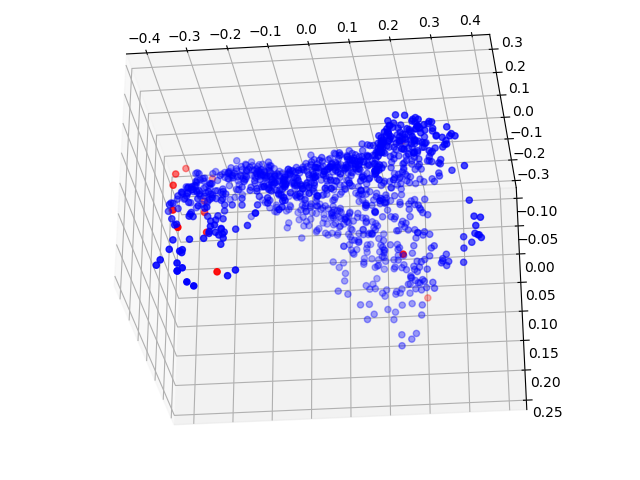

In [13]:
pred = infer(pc)
plot(pc, pred)